# Library imports, setup

In [62]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
from data import load_metadata, visualize_data, make_dataset
from model import build_cnn
from score_metrics import get_scores

In [64]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# check tf version
print(tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
for device in gpus:
    tf.config.experimental.set_memory_growth(device, True)
    print(f"Found GPU {device.name}, and set memory growth to True.")


2.20.0


# Loading data

In [65]:
image_metadata, species_metadata = load_metadata()
num_classes = len(species_metadata)

Number of classes: 296


d:\Egyetem_adat\kigyo2\snek\src\Models\data.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_metadata["encoded_id"] = encoder.fit_transform(image_metadata["class_id"])
d:\Egyetem_adat\kigyo2\snek\src\Models\data.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_metadata["image_path"] = image_metadata["image_path"].apply(


# Visualizing data

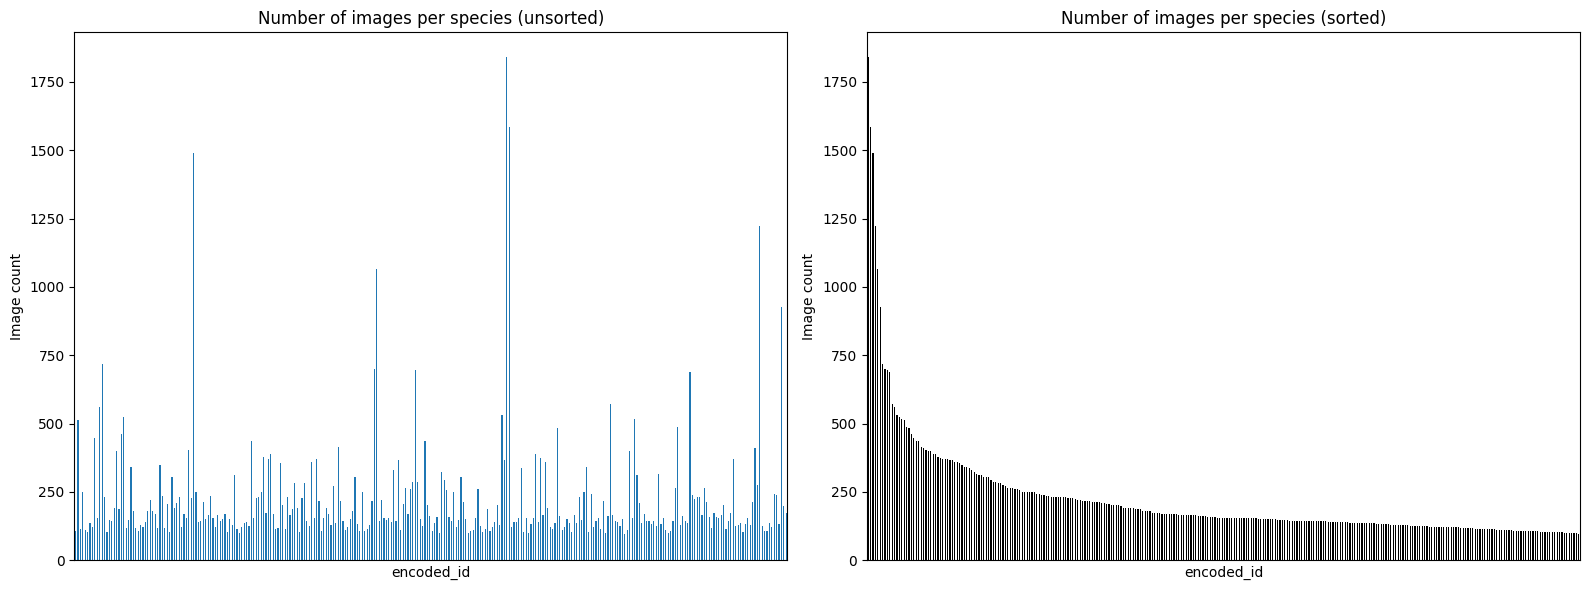

Maximum number per species class is 1839
Minimum number per species class is 96


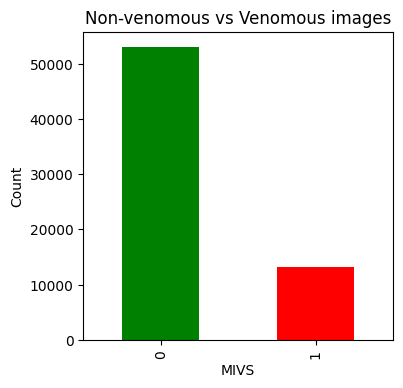

MIVS
0    53164
1    13290
Name: count, dtype: int64


In [66]:
#in data.py
visualize_data(image_metadata)

Loading python images from folder

# Building model

In [ ]:
IMAGE_RESOLUTION=256

train_dataset, val_dataset, test_dataset = make_dataset(image_metadata, IMAGE_RESOLUTION)

In [68]:
model=build_cnn(num_classes, IMAGE_RESOLUTION)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, None,      │        896 │ input_layer_5[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, None,      │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, None,      │     18,496 │ max_pooling2d_20… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, None,      │          0 │ conv2d_21[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, None,      │     73,856 │ max_pooling2d_21… │
│                     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_22    │ (None, None,      │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, None,      │     36,896 │ max_pooling2d_22… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_23    │ (None, None,      │          0 │ conv2d_23[0][0]   │
│ (MaxPooling2D)      │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ max_pooling2d_23… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │      4,224 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ species (Dense)     │ (None, 296)       │     38,184 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ venom (Dense)       │ (None, 1)         │        129 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 172,681 (674.54 KB)

 Trainable params: 172,681 (674.54 KB)

 Non-trainable params: 0 (0.00 B)

In [69]:
model.compile(
    optimizer='adam',
    
    loss={'species': 'sparse_categorical_crossentropy',
          'venom': 'binary_crossentropy'},

    metrics={'species': 'accuracy',
             'venom': 'accuracy'}
    )

In [71]:
n_epochs = 30

# checkpointing based on the validation loss
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('model.keras', monitor='val_loss', save_best_only=True, save_weights_only=False, verbose=1)

# model training
model_history = model.fit(
                            x= train_dataset,
                            epochs= n_epochs,
                            validation_data= val_dataset,
                            callbacks=[model_checkpoint_callback])

model.load_weights('model.keras')  # load weights back

Epoch 1/30
 351/1662 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - loss: 5.9768 - species_accuracy: 0.0267 - species_loss: 5.4668 - venom_accuracy: 0.7979 - venom_loss: 0.5100

KeyboardInterrupt: 

In [ ]:
test_history = model.evaluate(test_dataset)
print("Test Loss: ", test_history[0])
print("Test Accuracy: ", test_history[1])

208/208 ━━━━━━━━━━━━━━━━━━━━ 23s 111ms/step - loss: 5.8251 - species_accuracy: 0.0327 - species_loss: 5.3261 - venom_accuracy: 0.8008 - venom_loss: 0.4989
Test Loss:  5.825067520141602
Test Accuracy:  5.326133728027344


# Example results

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def example_results_from_dataset(model, ds, species_names, n_examples=5, venom_threshold=0.5):
    """
    ds must yield: (image, {'species': int, 'venom': int})
    species_names: list where index == encoded_id
    """
    # unbatch to individual samples and take a few
    samples = list(ds.unbatch().take(n_examples))
    imgs = [x[0] for x in samples]
    lbls = [x[1] for x in samples]

    # stack to a batch for one predict()
    x_batch = tf.stack(imgs, axis=0)
    pred_species_logits, pred_venom_prob = model.predict(x_batch, verbose=0)

    plt.figure(figsize=(3.3 * len(imgs), 3.3))
    for i, (img, y) in enumerate(zip(imgs, lbls), start=1):
        true_species = int(y["species"].numpy())
        true_venom   = int(y["venom"].numpy())

        pred_species = int(np.argmax(pred_species_logits[i-1]))
        pred_venom   = bool(float(pred_venom_prob[i-1][0]) > venom_threshold)

        true_name = species_names[true_species] if 0 <= true_species < len(species_names) else str(true_species)
        pred_name = species_names[pred_species] if 0 <= pred_species < len(species_names) else str(pred_species)

        plt.subplot(1, len(imgs), i)
        plt.imshow(img.numpy())
        plt.axis("off")
        plt.title(
            f"True: {true_name} ({'Venom' if true_venom else 'Safe'})\n"
            f"Pred: {pred_name} ({'Venom' if pred_venom else 'Safe'})",
            fontsize=9
        )
    plt.tight_layout(); plt.show()


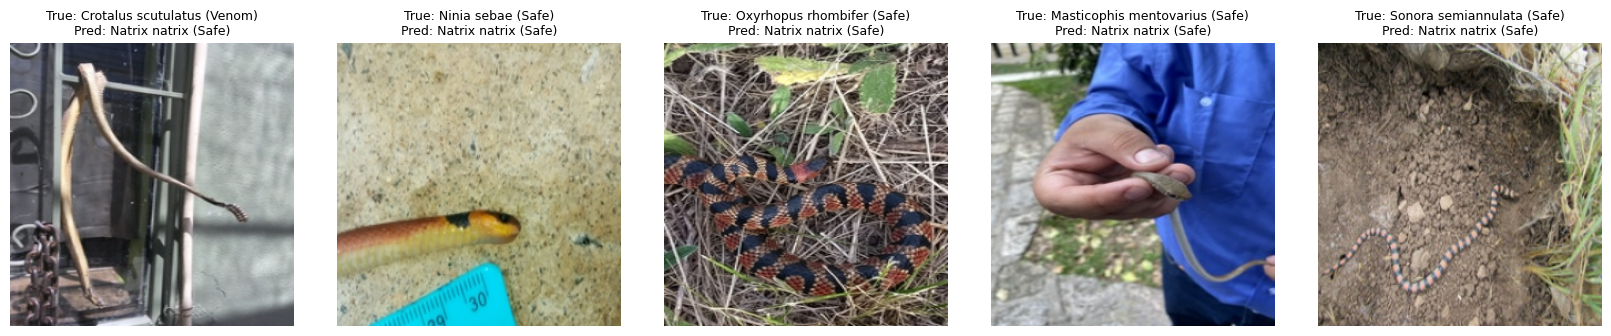

In [ ]:
example_results_from_dataset(model, test_dataset, species_metadata, n_examples=5)


# Calculating scoring metrics

Function to tell if the species is venomous or not, based on encoded_id

In [ ]:
get_scores(model, image_metadata, test_dataset, venom_threshold=0.5)

208/208 ━━━━━━━━━━━━━━━━━━━━ 19s 93ms/step
=== Evaluation Metrics ===
1) Species accuracy: 0.0327
2) Macro-averaged F1 (species): 0.0008
3) Venom decision accuracy: 0.8008
4) Venom-weighted species accuracy: 0.3208


{'species_accuracy': 0.032651218778212455,
 'macro_f1': 0.0007832455964347751,
 'venom_accuracy': 0.8007824255191093,
 'venom_weighted_species_accuracy': np.float64(0.32084105653382766),
 'y_species_true': array([ 61, 185, 201, ..., 150,  74, 154], shape=(6646,), dtype=int32),
 'y_species_pred': array([179, 179, 179, ..., 179, 179, 179], shape=(6646,)),
 'y_venom_true': array([1, 0, 0, ..., 0, 1, 0], shape=(6646,), dtype=int32),
 'y_venom_pred': array([0, 0, 0, ..., 0, 0, 0], shape=(6646,))}